<a href="https://colab.research.google.com/github/shivanguniyal-polcon/Machine-Learning/blob/main/Shivang_Uniyal_A1_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
file_path = '/content/drive/My Drive/crime_ml.csv'

df = pd.read_csv(path+file)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# //////////////////////////////
# 1. DATA LOADING & CLEANING //
# ////////////////////////////
print("--- 1. Loading and Cleaning Data ---")


df = pd.read_csv(file_path, na_values='?')
print(f"Initial Shape: {df.shape}")

# STRATEGY FOR MISSING DATA:
# 1. Drop columns with >10% missing values (These are likely the specific racial_PerCap variables)
# 2. Impute the remaining missing values with the median.
limit = len(df) * 0.9
df = df.dropna(thresh=limit, axis=1) #checking for threshold in columns

df = df.fillna(df.median(numeric_only=True)) #calculates the median for numeric values and inserts in columns in <10% missing data

print(f"Shape after cleaning: {df.shape}")

--- 1. Loading and Cleaning Data ---
Initial Shape: (2215, 147)


In [59]:
# ////////////////////////
# 2.FEATURE DEFINITION //
# //////////////////////

target = 'violentcrimesperpop'
df.columns = df.columns.str.lower() #to ensure any typos don't pose problems in reading column names

# COLUMNS TO DROP
# 1. Identifiers (useless for prediction)
identifying_cols = ['communityname', 'state', 'countycode', 'communitycode', 'fold']

# 2. LEAKAGE VARIABLES (The sub-crimes that sum up to the target)
# We MUST remove these, or the model cheats.
leakage_cols = [
    'murdperpop', 'rapesperpop', 'robbbperpop', 'assaultperpop',
    'burglperpop', 'larcperpop', 'autotheftperpop', 'arsonsperpop',
    'nonviolperpop' # Remove non-violent too if predicting violent
]

#3. Racial terms (These are needed for bias analysis, so we will not drop them from X_all initially)
race_cols = [
    'racepctblack',
    'racepctwhite',
    'racepctasian',
    'racepcthisp',
    'whitepercap',
    'blackpercap',
    'indianpercap',
    'asianpercap',
    'otherpercap',
    'hisppercap'
]

# 3. Combine drops (DO NOT drop racial terms here, they are needed later)
cols_to_drop = identifying_cols + leakage_cols + [target]

# Create X (Features) and y (Target)
X_all = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df[target]

In [66]:
# ////////////////////
# 3. SPLIT & SCALE //
# //////////////////

# 80/20 Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Standardize features (Required for Lasso/Ridge/ElasticNet)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)


In [61]:
# //////////////////////////////
# 4. PART A: MODEL SELECTION //
# ////////////////////////////
print("\n--- 2. Model Selection (5-Fold CV) ---")

# We use *CV classes to automatically tune the regularization parameter (alpha)

# A. LASSO
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
lasso_r2 = r2_score(y_test, lasso.predict(X_test_scaled))

# B. RIDGE
ridge = RidgeCV(cv=5).fit(X_train_scaled, y_train)
ridge_r2 = r2_score(y_test, ridge.predict(X_test_scaled))

# C. ELASTIC NET
enet = ElasticNetCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
enet_r2 = r2_score(y_test, enet.predict(X_test_scaled))

print(f"Lasso Test R2:      {lasso_r2:.4f}")
print(f"Ridge Test R2:      {ridge_r2:.4f}")
print(f"ElasticNet Test R2: {enet_r2:.4f}")

# Select Best Model automatically
best_score = max(lasso_r2, ridge_r2, enet_r2)
if best_score == lasso_r2:
    best_model = lasso
    model_name = "Lasso"
elif best_score == ridge_r2:
    best_model = ridge
    model_name = "Ridge"
else:
    best_model = enet
    model_name = "ElasticNet"

print(f"Best Model Selected: {model_name}")


--- 2. Model Selection (5-Fold CV) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120560.32118880749, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260853.12112107873, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316309.8063774407, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergen

Lasso Test R2:      0.6011
Ridge Test R2:      0.6145
ElasticNet Test R2: 0.5491
Best Model Selected: Ridge


In [62]:
# ///////////////////////////////
# 5. PART B: THREE VARIATIONS //
# /////////////////////////////
print("\n--- 3. Running Variations (Bias Analysis) ---")

# Separate "Race" features from "Non-Race" features
non_race_cols = [c for c in X_train_scaled.columns if c not in race_cols]
X_train_race = X_train_scaled[race_cols]
X_test_race = X_test_scaled[race_cols]

# --- CASE 1: OMIT RACIAL PREDICTORS ---
X_train_1 = X_train_scaled[non_race_cols]
X_test_1 = X_test_scaled[non_race_cols]

model_1 = LassoCV(cv=5, random_state=42).fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_test_1)
print(f"Case 1 (Omit Race) R2: {r2_score(y_test, y_pred_1):.4f}")


# --- CASE 2: OMIT + ORTHOGONALIZE ---
# Regress Non-Race features on Race features to remove correlation
print("Orthogonalizing features... (This removes shared information)")

# We fit a LinearRegression to predict 'Income' using 'Race'.
# The residuals (Errors) are the part of 'Income' that has nothing to do with Race.
ortho_transformer = LinearRegression().fit(X_train_race, X_train_1)

X_train_2 = X_train_1 - ortho_transformer.predict(X_train_race)
X_test_2 = X_test_1 - ortho_transformer.predict(X_test_race)

model_2 = LassoCV(cv=5, random_state=42).fit(X_train_2, y_train)
y_pred_2 = model_2.predict(X_test_2)
print(f"Case 2 (Orthogonalized) R2: {r2_score(y_test, y_pred_2):.4f}")


# --- CASE 3: FULLY INTERACTED MODEL ---
# Add features: Feature * racepctblack (Focusing on Black share for interaction)
print("Creating interaction terms...")

X_train_3 = X_train_scaled.copy()
X_test_3 = X_test_scaled.copy()

# Note: We specifically interact with 'racepctblack' as it is the primary variable of interest for bias
# If 'racepctblack' was dropped during cleaning, skip this or pick next available race var.
if 'racepctblack' in X_train_scaled.columns:
    target_race_col = 'racepctblack'

    for col in non_race_cols:
        # Create interaction columns
        X_train_3[f"{col}_x_Black"] = X_train_3[col] * X_train_3[target_race_col]
        X_test_3[f"{col}_x_Black"] = X_test_3[col] * X_test_3[target_race_col]

    model_3 = LassoCV(cv=5, random_state=42).fit(X_train_3, y_train)
    y_pred_3 = model_3.predict(X_test_3)
    print(f"Case 3 (Interacted) R2: {r2_score(y_test, y_pred_3):.4f}")
else:
    print("Warning: 'racepctblack' missing from data. Skipping Case 3.")
    y_pred_3 = np.zeros_like(y_test) # Placeholder


--- 3. Running Variations (Bias Analysis) ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129925.46898531914, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275973.4621042609, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 329266.1890554726, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

Case 1 (Omit Race) R2: 0.6027
Orthogonalizing features... (This removes shared information)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128156.54811233282, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 310580.0309871435, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70181.51328378916, tolerance: 50535.038013173384
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

Case 2 (Orthogonalized) R2: 0.1242
Creating interaction terms...


/tmp/ipython-input-66230840.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_3[f"{col}_x_Black"] = X_train_3[col] * X_train_3[target_race_col]
/tmp/ipython-input-66230840.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_3[f"{col}_x_Black"] = X_test_3[col] * X_test_3[target_race_col]
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89729.31041094661, toler

Case 3 (Interacted) R2: 0.5204


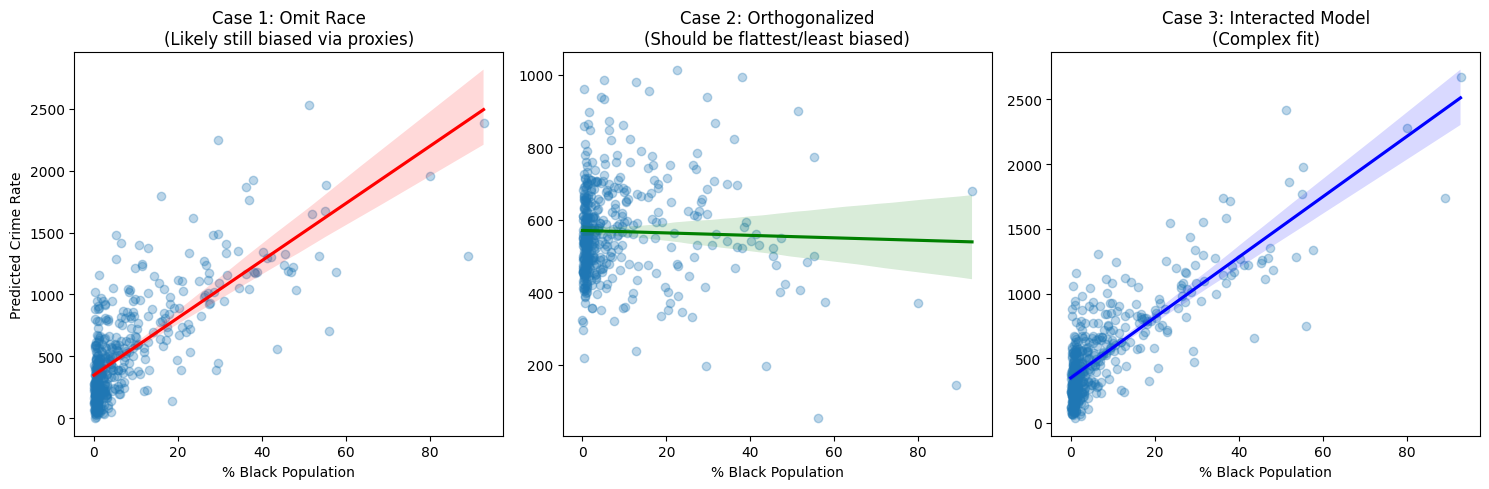

Plots generated. Look for the slope of the line to interpret bias.


In [63]:
# ///////////////////////
# 6. PLOTS & ANALYSIS //
# /////////////////////

# Plot predicted crime vs Black Population Share
if 'racepctblack' in X_test_raw.columns:
    plot_df = pd.DataFrame({
        'Black_Share': X_test_raw['racepctblack'], # Raw % for interpretability
        'Pred_Omit': y_pred_1,
        'Pred_Ortho': y_pred_2,
        'Pred_Interact': y_pred_3
    })

    plt.figure(figsize=(15, 5))

    # 1. Omit Race
    plt.subplot(1, 3, 1)
    sns.regplot(data=plot_df, x='Black_Share', y='Pred_Omit',
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title("Case 1: Omit Race\n(Likely still biased via proxies)")
    plt.xlabel("% Black Population")
    plt.ylabel("Predicted Crime Rate")

    # 2. Orthogonalized
    plt.subplot(1, 3, 2)
    sns.regplot(data=plot_df, x='Black_Share', y='Pred_Ortho',
                scatter_kws={'alpha':0.3}, line_kws={'color':'green'})
    plt.title("Case 2: Orthogonalized\n(Should be flattest/least biased)")
    plt.xlabel("% Black Population")
    plt.ylabel("")

    # 3. Interacted
    plt.subplot(1, 3, 3)
    sns.regplot(data=plot_df, x='Black_Share', y='Pred_Interact',
                scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
    plt.title("Case 3: Interacted Model\n(Complex fit)")
    plt.xlabel("% Black Population")
    plt.ylabel("")

    plt.tight_layout()
    plt.show()
    print("Plots generated. Look for the slope of the line to interpret bias.")

In [64]:
# //////////////////////////////////////
# 7. INTERPRETABILITY (Top Features) //
# ////////////////////////////////////

# Let's see which interaction terms matter in Case 3
if 'model_3' in locals():
    coefs = pd.Series(model_3.coef_, index=X_train_3.columns)

    # Filter for interaction terms
    interaction_coefs = coefs[coefs.index.str.contains("_x_Black")]

    print("\n--- Explainability: Top Interaction Features ---")
    print("These features behave differently depending on the racial composition:")
    print(interaction_coefs.abs().sort_values(ascending=False).head(5))


--- Explainability: Top Interaction Features ---
These features behave differently depending on the racial composition:
pcthousless3br_x_Black      19.605807
pctunemployed_x_Black       19.510645
pctvacantboarded_x_Black    18.752094
pctimmigrec10_x_Black       18.277072
rapes_x_Black               14.660349
dtype: float64
